In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import tensorflow as tf
#from tensorflow.contrib.data import Dataset, Iterator
#import sklearn.cross_validation as sk
import warnings; warnings.simplefilter('ignore')
import cv2
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import sys
import random
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,Callback
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix

from astropy.io import fits
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy import stats
import numpy as np
import time
from datetime import timedelta


In [100]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [101]:
Data = pd.read_csv('sample/trainCatalogCombinedNew.csv')


In [102]:
Data.head()

,class_Jorge,runID,ohdu,eventID,classID_Jorge,class_Diego,classID_Diego,class_Javier,classID_Javier,agreeFlag
0,undefined,6378,5,233,3,undefined,3,undefined,3,True
1,muon_sure,6704,5,628,0,muon_sure,0,muon_sure,0,True
2,error de segmentacion,7228,2,163,4,error de segmentacion,4,error de segmentacion,4,True
3,error de segmentacion,6609,5,137,4,error de segmentacion,4,error de segmentacion,4,True
4,error de segmentacion,7279,5,168,4,error de segmentacion,4,error de segmentacion,4,True


In [103]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class_Jorge     2073 non-null   object
 1   runID           2073 non-null   int64 
 2   ohdu            2073 non-null   int64 
 3   eventID         2073 non-null   int64 
 4   classID_Jorge   2073 non-null   int64 
 5   class_Diego     2073 non-null   object
 6   classID_Diego   2073 non-null   int64 
 7   class_Javier    2073 non-null   object
 8   classID_Javier  2073 non-null   int64 
 9   agreeFlag       2073 non-null   bool  
dtypes: bool(1), int64(6), object(3)
memory usage: 147.9+ KB


In [104]:
Data["muon"] = Data.classID_Jorge==0
size=112

In [105]:
def preprocessing(matrix,size):
    #************************
    #funcion que recibe una matriz imagen, y hace el preprocesamiento necesario, jutno con el resize y agregado de 0s
    #*************
    #convertir a numpy array
    data = np.array(matrix)
    #quitar los valores negativos
    data = np.where(data<0, 0, data)
    #convertir a escala logaritmica
   # data = np.uint8(np.log1p(data))
    data = (np.sqrt(data))
    
    #normalizar a 0-255
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8U)
    
    #resize
    if data.shape[1] == data.shape[0]:
        result = cv2.resize(data,(size,size), interpolation = cv2.INTER_NEAREST)
        
    elif data.shape[0] > data.shape[1]:
        resized = cv2.resize(data,(int(data.shape[1]*size/data.shape[0]),size), interpolation = cv2.INTER_NEAREST)
        sumar = int((size - resized.shape[1])/2)
        if resized.shape[1]%2 == 0:
            result = np.pad(resized, ((0,0),(sumar,sumar)) , mode='median')
        else:
            result = np.pad(resized, ((0,0),(sumar+1,sumar)) , mode='median')
            
    elif data.shape[1]> data.shape[0]:
        resized = cv2.resize(data,(size,int(data.shape[0]*size/data.shape[1])), interpolation = cv2.INTER_NEAREST)
        sumar = int((size - resized.shape[0])/2)
        if resized.shape[0]%2 == 0:
            result = np.pad(resized, ((sumar,sumar),(0,0)) , mode='median')
        else:
            result = np.pad(resized, ((sumar+1,sumar),(0,0)) , mode='median')
    return result




In [112]:
Pwd='/tf/Documentos/CONNIEData/eventsFits/'
#crear los vectores x con las matrices ya procesadas (de 64x64) y el vector y con las etiquetas
data = []
labels = []
for row in Data.iterrows():
    fits_image_filename =Pwd+str(row[1].runID)+'/catalog' +str(row[1].runID)+ '_' +str(row[1].ohdu)+'_' + str(row[1].eventID) + '.fits'
    with fits.open(fits_image_filename,memmap=False) as hdul:
        scidata = hdul[0].data
        del hdul
    mat = preprocessing(scidata,size)
    if(row[1].muon):
            data.append(mat)
            labels.append(row[1].muon)
            for par in (0,1,-1):
                data.append(cv2.flip(mat, par))
                labels.append(row[1].muon)
    else:
        data.append(mat)
        labels.append(row[1].muon)


print (len(data))
print (len(labels))
print ('muonSure:\t' + str( labels.count(True)))



3177
3177
muonSure:	1472


In [113]:
 data=np.array(data)
    

In [114]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); print(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [115]:
from sklearn.utils import class_weight

In [116]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.argmax(trainY, axis=1)),
                                                 np.argmax(trainY, axis=1))
d_class_weights = dict(enumerate(class_weights))

In [117]:
print(d_class_weights )

{0: 0.9314516129032258, 1: 1.0794392523364487}


In [118]:
trainX =np.expand_dims(trainX, axis=3)
testX = np.expand_dims(testX, axis=3)
trainX = np.concatenate( [trainX,trainX,trainX], axis=-1 )
testX = np.concatenate( [testX,testX,testX], axis=-1)


In [119]:
print(np.shape(trainX))

(2541, 112, 112, 3)


In [120]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY =img.std()*(random.random()*2)
    deviation = VARIABILITY#*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img=np.clip(img, 0., 255.)
   # frame=increase_brightness(img, value=()*random.random())
    return img


In [121]:
trainAug = ImageDataGenerator(
   # horizontal_flip=True,
   # vertical_flip=True,
    width_shift_range=(-2, 2),
    height_shift_range=(-2, 2),
    zoom_range=[0.9, 1.1],
    preprocessing_function=add_noise,
    fill_mode="nearest")

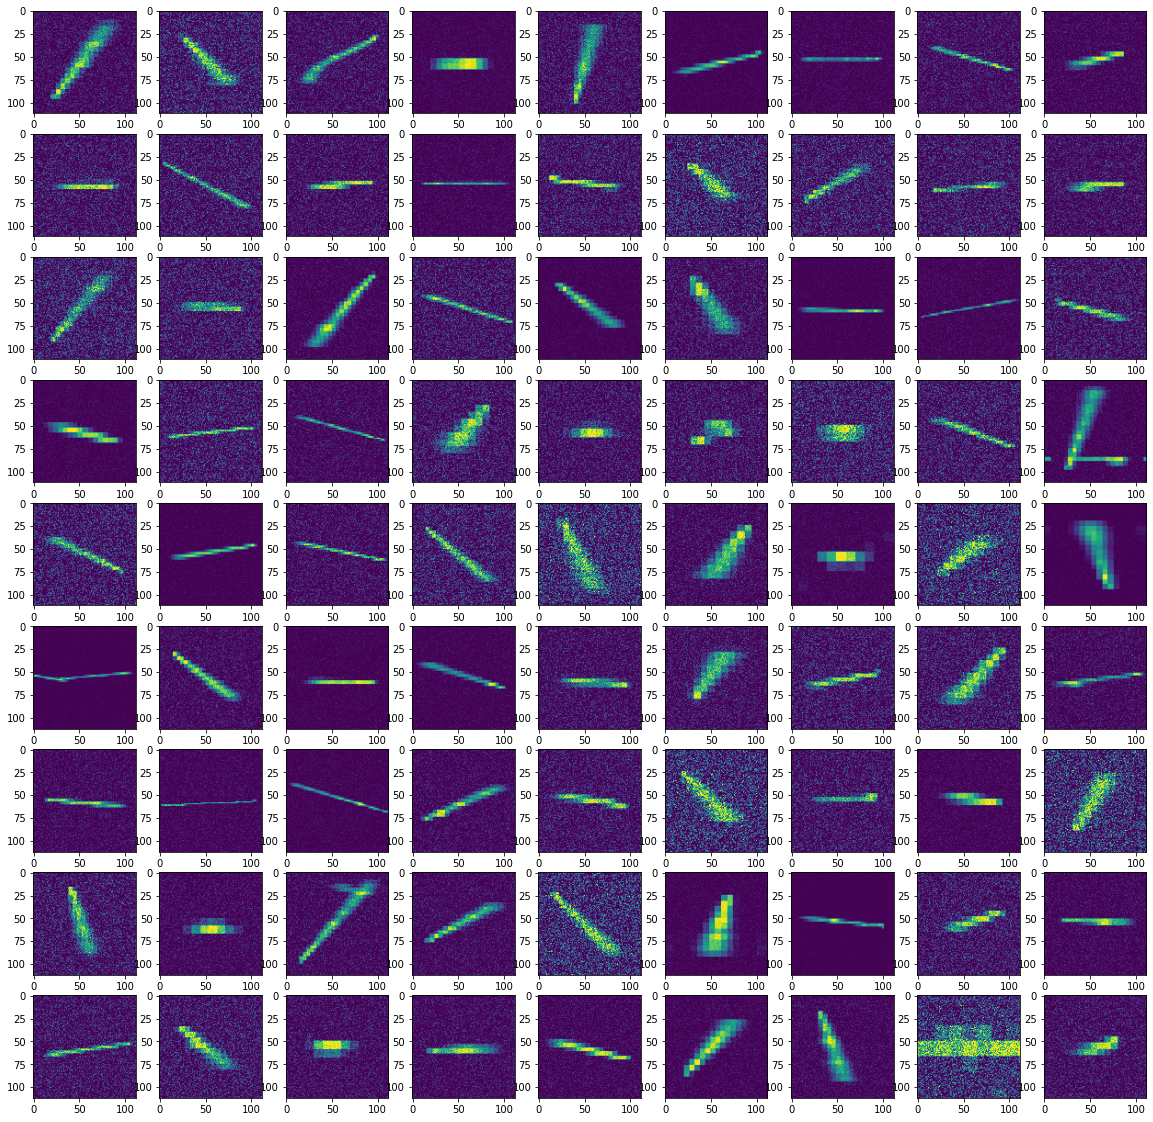

In [122]:
if(True):
    fig=plt.figure(figsize=(20,20))

    it = trainAug.flow(trainX, trainY, batch_size=1)
    # generate samples and plot
    for i in range(81):
        # define subplot
        plt.subplot(9,9 , i+1)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0]
        # plot raw pixel data
        I=image[0,:,:,0]
        plt.imshow(I)
       # print(I.min(),I.mean(),I.max())
    # show the figure
    plt.show()

In [123]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
#kf = StratifiedKFold(n_splits=5,shuffle=True)


In [124]:
print(np.shape(trainX))

(2541, 112, 112, 3)


In [ ]:
INIT_LR = 1e-6
EPOCHS = 100
BS = 80
modelpath="modelos/VGG16-8020crossvalFinal/"
i=0
conf=[]

accc=[]
for train_index, test_index in kf.split(trainX):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    trainX_k, testX_k = trainX[train_index], trainX[test_index]
    trainY_k, testY_k= trainY[train_index], trainY[test_index]
    
    i=i+1
    vgg_pretrained_model = VGG16(weights="imagenet", 
                                 include_top= False,
                                 input_tensor=Input(shape=(size, size,3)))
    new_model = vgg_pretrained_model.output
    new_model = AveragePooling2D(pool_size=(3, 3))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(64, activation="relu")(new_model)
    new_model = Dropout(0.5)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg_pretrained_model.input, outputs=new_model)
    model_json = model.to_json()
    with open(modelpath+"model.json", "w") as json_file:
        json_file.write(model_json)
    filepath=modelpath+str(i)+"best_model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, mode='auto')
    callbacks_list = [checkpoint,early_stopping]
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=["accuracy"]),
    print("[INFO] training head...")
    start_time = time.monotonic()
    H = model.fit_generator(
        trainAug.flow(trainX_k, trainY_k, batch_size=BS),class_weight=d_class_weights ,
        steps_per_epoch=len(trainX_k)// BS,
        validation_data=(testX_k, testY_k),
        callbacks=callbacks_list,
        validation_steps=len(testX_k)// BS,epochs=EPOCHS)
    end_time = time.monotonic()
    print(timedelta(seconds=end_time - start_time))
    model.save_weights(modelpath+str(i)+"model.h5")
    print("Saved model to disk")
    model = load_model(filepath)
    predIdxs = model.predict(testX_k, batch_size=BS)
    predIdxs = np.argmax(predIdxs, axis=1)
    print(classification_report(testY_k.argmax(axis=1), predIdxs))
    accc.append(classification_report(testY_k.argmax(axis=1), predIdxs))

    N = len(H.history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="best")
    plt.savefig(modelpath+str(i)+"train.png")
    cm = confusion_matrix(testY_k.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    print(cm)
    conf.append(cm)
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))


In [126]:
for acc,cf in zip(accc,conf):
    print(acc)
    print(cf)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       290
           1       0.94      0.99      0.96       219

    accuracy                           0.97       509
   macro avg       0.96      0.97      0.97       509
weighted avg       0.97      0.97      0.97       509

[[275  15]
 [  2 217]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       282
           1       0.94      1.00      0.97       226

    accuracy                           0.97       508
   macro avg       0.97      0.97      0.97       508
weighted avg       0.97      0.97      0.97       508

[[268  14]
 [  1 225]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       279
           1       0.97      1.00      0.98       229

    accuracy                           0.98       508
   macro avg       0.98      0.99      0.98       508
weighted avg       0.98     

In [130]:
for i in range(1,6):
    filepath=modelpath+str(i)+"best_model.h5"
    #filepath="modelos/VGG16-8020crossval/best_model.h5"
    
    print("Saved model to disk")
    model = load_model(filepath)
    print("[INFO] evaluating network...")
    predIdxs = model.predict(testX, batch_size=BS)
    predIdxs = np.argmax(predIdxs, axis=1)
    print(classification_report(testY.argmax(axis=1), predIdxs))

    cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    print(cm)
    print("acc: {:.4f}".format(acc))
    print("sensitivity: {:.4f}".format(sensitivity))
    print("specificity: {:.4f}".format(specificity))

Saved model to disk
[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       341
           1       0.96      0.99      0.97       295

    accuracy                           0.98       636
   macro avg       0.98      0.98      0.98       636
weighted avg       0.98      0.98      0.98       636

[[330  11]
 [  4 291]]
acc: 0.9764
sensitivity: 0.9677
specificity: 0.9864
Saved model to disk
[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       341
           1       0.97      0.98      0.97       295

    accuracy                           0.97       636
   macro avg       0.97      0.98      0.97       636
weighted avg       0.97      0.97      0.97       636

[[331  10]
 [  6 289]]
acc: 0.9748
sensitivity: 0.9707
specificity: 0.9797
Saved model to disk
[INFO] evaluating network...
              precision    recall  f1-score   sup

In [71]:
from pickle import dump,load

In [72]:
dump(testX, open('pkl/testX.pkl', 'wb'))
dump(testY, open('pkl/testY.pkl', 'wb'))
dump(trainX, open('pkl/trainX.pkl', 'wb'))
dump(trainY, open('pkl/trainY.pkl', 'wb'))

In [73]:
model.save("modelos/VGG16-8020crossvalFinal/best_model.h5")
